## What is infer_signature in MLflow?
The infer_signature function in MLflow automatically detects the input and output schemas (or data structures) of a machine learning model. These schemas, referred to as the model signature, describe:

- Input Schema: The shape, type, and structure of the features used by the model.
- Output Schema: The type and structure of the predictions made by the model.


It is added as metadata when logging the model, enabling validation and making the model reusable across various environments.

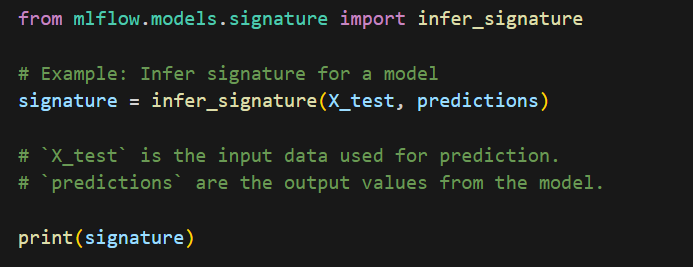

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import mlflow
from mlflow.models.signature import infer_signature

In [3]:
# Step 1: Load Dataset
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

In [12]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [13]:
y


0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [4]:
# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Step 3: Train a Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [6]:
# Step 4: Make Predictions
predictions = model.predict(X_test)

In [7]:
# Step 5: Evaluate Model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.555891598695244
R^2 Score: 0.5757877060324511


In [8]:
# Step 6: Infer Signature
signature = infer_signature(X_test, predictions)

In [9]:
# Step 7: Log Model with MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Use local directory for tracking
mlflow.set_experiment("Regression Problem with MLflow")

<Experiment: artifact_location='mlflow-artifacts:/313554558950829474', creation_time=1735826192136, experiment_id='313554558950829474', last_update_time=1735826192136, lifecycle_stage='active', name='Regression Problem with MLflow', tags={}>

In [10]:
with mlflow.start_run():
    # Log Model
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="linear_regression_model",
        signature=signature,
        input_example=X_test.head(1)  # Optional: Example input
    )
    # Log Metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

print("Model logged successfully!")

c:\Users\Asus\anaconda3\envs\venv-mlflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/01/02 19:34:17 INFO mlflow.models.model: Found the following environment variables used during model inference: [AI21_API_KEY, HUGGINGFACEHUB_API_TOKEN]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🏃 View run bold-whale-693 at: http://127.0.0.1:5000/#/experiments/313554558950829474/runs/e6d34337648843fe8305f37ea439b573
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/313554558950829474
Model logged successfully!


In [11]:
# Step 8: Load and Test the Model
#logged_model_uri = "runs:/{run_id}/linear_regression_model"
logged_model_uri = "runs:/979276b345c2464cb86505ae0077c841/linear_regression_model"
loaded_model = mlflow.pyfunc.load_model(logged_model_uri)
test_prediction = loaded_model.predict(X_test.head(1))
print("Test Prediction:", test_prediction)

Test Prediction: [0.71912284]


In [14]:
from mlflow.models import validate_serving_input

model_uri = 'runs:/979276b345c2464cb86505ae0077c841/linear_regression_model'

# The model is logged with an input example. MLflow converts
# it into the serving payload format for the deployed model endpoint,
# and saves it to 'serving_input_payload.json'
serving_payload = """{
  "dataframe_split": {
    "columns": [
      "MedInc",
      "HouseAge",
      "AveRooms",
      "AveBedrms",
      "Population",
      "AveOccup",
      "Latitude",
      "Longitude"
    ],
    "data": [
      [
        1.6812,
        25.0,
        4.192200557103064,
        1.0222841225626742,
        1392.0,
        3.8774373259052926,
        36.06,
        -119.01
      ]
    ]
  }
}"""

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

array([0.71912284])